# Introduction

This notebook provides a tutorial on how to use pymatgen's basic functionality, and how to interact with the Materials API through pymatgen's high-level interface.

Let's start with some basic imports of the classes/methods we need.

In [1]:
from pymatgen import MPRester, Structure, Lattice, Element
from pprint import pprint

## Basic functionality of pymatgen

Now, let us create the SrTiO3 cubic perovskite manually from a spacegroup.

In [2]:
perovskite = Structure.from_spacegroup(
    "Pm-3m",  # CsCl has the primitive cubic spacegroup Pm-3m
    Lattice.cubic(3),  # We use the convenient constructor to generate a cubic lattice with lattice parameter 3.
    ["Sr", "Ti", "O"],  # These are the two unique species.
    [[0,0,0], [0.5, 0.5, 0.5], [0.5, 0.5, 0]]  # These are the fractional coordinates.
)

Let us now see the structure.

In [3]:
print(perovskite)

Full Formula (Sr1 Ti1 O3)
Reduced Formula: SrTiO3
abc   :   3.000000   3.000000   3.000000
angles:  90.000000  90.000000  90.000000
Sites (5)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Sr    0    0    0
  1  Ti    0.5  0.5  0.5
  2  O     0.5  0.5  0
  3  O     0    0.5  0.5
  4  O     0.5  0    0.5


The Structure object provides methods to export the structure to a Crystallographic Information File (CIF) and other formats that can be opened by a wide variety of materials science software.

In [4]:
perovskite.to(filename="SrTiO3.cif")

Similarly, we can read a Structure from many common file formats.

In [5]:
perov_from_file = Structure.from_file("SrTiO3.cif")
print(perov_from_file)  # Just to confirm that we have the same structure.

Full Formula (Sr1 Ti1 O3)
Reduced Formula: SrTiO3
abc   :   3.000000   3.000000   3.000000
angles:  90.000000  90.000000  90.000000
Sites (5)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Sr    0    0    0
  1  Ti    0.5  0.5  0.5
  2  O     0.5  0.5  0
  3  O     0    0.5  0.5
  4  O     0.5  0    0.5


Very often, we want to manipulate an existing to create a new structure. Here, we will apply a strain in the c direction followed by a substitution of Sr with Ba to create a tetragonal form of BaTiO3.

In [6]:
new_structure = perovskite.copy()
new_structure.apply_strain([0, 0, 0.1])
new_structure["Sr"] = "Ba"
print(new_structure)

Full Formula (Ba1 Ti1 O3)
Reduced Formula: BaTiO3
abc   :   3.000000   3.000000   3.300000
angles:  90.000000  90.000000  90.000000
Sites (5)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Ba    0    0    0
  1  Ti    0.5  0.5  0.5
  2  O     0.5  0.5  0
  3  O     0    0.5  0.5
  4  O     0.5  0    0.5


We can determine the spacegroup of this new structure. We get a tetragonal space group as expected.

In [7]:
print(new_structure.get_space_group_info())

('P4/mmm', 123)


Pymatgen comes with many powerful analysis tools. There are too many to go through. Here, we will present a few examples.

Analysis 1: Plotting the XRD pattern

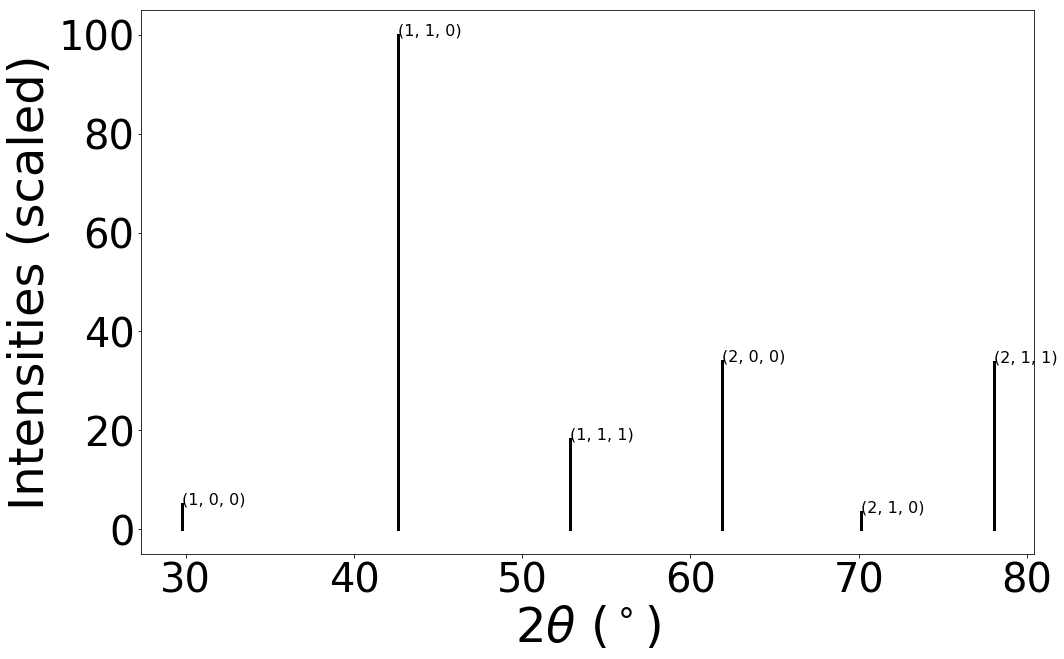

In [8]:
%matplotlib inline
from pymatgen.analysis.diffraction.xrd import XRDCalculator
c = XRDCalculator()
c.show_plot(perovskite)

Analysis example 2: Generating surface structures

This code was used extensively in the creating of [Crystalium](http://crystalium.materialsvirtuallab.org).

In [9]:
from pymatgen.core.surface import generate_all_slabs

In [10]:
slabs = generate_all_slabs(perovskite, 2, 10, 10)
for slab in slabs:
    print(slab.miller_index)

(1, 1, 1)
(2, 2, 1)
(1, 1, 0)
(2, 1, 1)
(2, 1, 0)
(1, 0, 0)


## Using the Materials API

pymatgen provides a high-level interface to the Materials Project API called MPRester. Using MPRester, you can easily grab almost any piece of data from the Materials Project easily. Here we demonstrate some of the high level functions. To use the Materials API, you need to already have an account and an API key from the Materials Project. Get it at https://www.materialsproject.org/dashboard.

In [11]:
mpr = MPRester()

In [12]:
entries = mpr.get_entries("CsCl", inc_structure=True)

In [13]:
for e in entries:
    print(e.structure)
    print(e.structure.get_space_group_info())
    print(e.energy_per_atom)

Full Formula (Cs1 Cl1)
Reduced Formula: CsCl
abc   :   4.209055   4.209055   4.209055
angles:  90.000000  90.000000  90.000000
Sites (2)
  #  SP      a    b    c    magmom
---  ----  ---  ---  ---  --------
  0  Cl    0.5  0.5  0.5         0
  1  Cs    0    0    0           0
('Pm-3m', 221)
-3.272153125
Full Formula (Cs1 Cl1)
Reduced Formula: CsCl
abc   :   4.993598   4.993599   4.993598
angles:  60.000001  59.999999  60.000005
Sites (2)
  #  SP      a    b    c    magmom
---  ----  ---  ---  ---  --------
  0  Cs    0    0    0           0
  1  Cl    0.5  0.5  0.5         0
('Fm-3m', 225)
-3.31995151


## Simple machine learning with Materials Project data

Here, I will demonstrate a simple machine learning exercise using data from the Materials Project using pymatgen combined with numpy. Pymatgen's Element object has all the elemental melting points available. Materials Project has computed the elastic constants of all the elements. Is there a relationship between the bulk modulus of an element and its melting point?

For the purposes of this exercise, we will be using the powerful `query` method in MPRester, which essentially allows a user to submit any type of data request to the Materials Project. We will demonstrate the basic principles, and to find out more, please go to http://bit.ly/materialsapi for more information on how to do more sophisticated queries.

In [14]:
criteria = {
    "nelements": 1,  # This specifies we are getting data on materials with only one species, i.e., elements
    "elasticity": {"$exists": True}  # We only want elements with elasticity data.
}
properties = [
    "elements",
    "task_id",
    "final_energy_per_atom",
    "elasticity.K_VRH"
]

data = mpr.query(criteria=criteria, properties=properties)
print(len(data))
print(data[0])

312
{'elements': ['Ac'], 'task_id': 'mp-862690', 'final_energy_per_atom': -4.1057071225, 'elasticity.K_VRH': 29.0}


In [15]:
melting_points = []
bulk_moduli = []
for d in data:
    melting_points.append(Element(d["elements"][0]).melting_point)
    bulk_moduli.append(d["elasticity.K_VRH"])

/Users/shyue/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


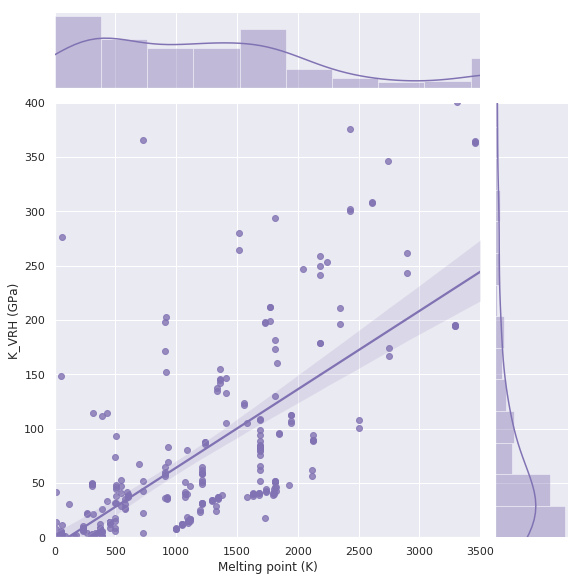

In [16]:
import seaborn as sns
sns.set(style="darkgrid")

g = sns.jointplot(melting_points, bulk_moduli, kind="reg",
                  xlim=(0, 3500), ylim=(0, 400), color="m", height=8)
import matplotlib.pyplot as plt
label = plt.xlabel("Melting point (K)")
label = plt.ylabel("K_VRH (GPa)")

We will use scipy to get the linear equation line.

In [24]:
from scipy import stats
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(melting_points, bulk_moduli)
print("K_VRH = {0:.1f} Melting_Point {1:.1f}".format(slope,intercept))
print("R = %.4f" % r_value)

K_VRH = 0.1 Melting_Point -8.0
R = 0.7379


The problem with the above analysis is that it includes all polymorphs of the same element. Obviously, the melting point refers to the standard state of the element. We will use the ground state (lowest energy per atom) of each element as the representative data instead.

In [20]:
import itertools
data = sorted(data, key=lambda d: d["elements"][0])
melting_points_gs = []
bulk_moduli_gs = []
for k, g in itertools.groupby(data, key=lambda d: d["elements"][0]):
    gs_data = min(g, key=lambda d: d["final_energy_per_atom"])
    melting_points_gs.append(Element(k).melting_point)
    bulk_moduli_gs.append(gs_data["elasticity.K_VRH"])

/Users/shyue/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


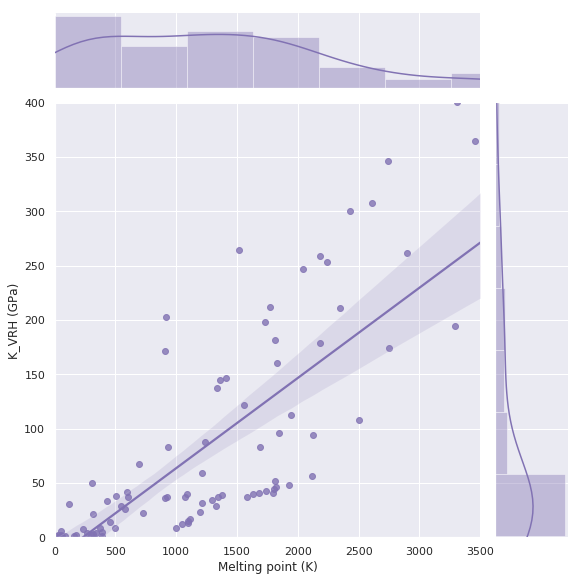

In [21]:
g = sns.jointplot(melting_points_gs, bulk_moduli_gs, kind="reg",
                  xlim=(0, 3500), ylim=(0, 400), color="m", height=8)
import matplotlib.pyplot as plt
label = plt.xlabel("Melting point (K)")
label = plt.ylabel("K_VRH (GPa)")

In [25]:
slope, intercept, r_value, p_value, std_err = stats.linregress(melting_points_gs, bulk_moduli_gs)
print("K_VRH = {0:.1f} Melting_Point {1:.1f}".format(slope,intercept))
print("R = %.4f" % r_value)

K_VRH = 0.1 Melting_Point -19.3
R = 0.7721


## Lasso

Let us now use a more sophisticated machine learning approach - LASSO. We will use the scikit-learn package. Instead of assuming that the bulk modulus can be predicted from just the melting point, we will now use multiple variables, including the melting point, boiling point, electronegativity, atomic number, atomic radius.

In [79]:
parameters_gs = []
bulk_moduli_gs = []
for k, g in itertools.groupby(data, key=lambda d: d["elements"][0]):
    gs_data = min(g, key=lambda d: d["final_energy_per_atom"])
    el = Element(k)
    if (not el.is_noble_gas) and el.boiling_point:
        parameters_gs.append([el.melting_point, el.boiling_point, el.Z, el.X, el.atomic_radius])
        bulk_moduli_gs.append(gs_data["elasticity.K_VRH"])

In [80]:
from sklearn import linear_model
reg = linear_model.Lasso(alpha=0.3, max_iter=10000)
reg.fit(parameters_gs, bulk_moduli_gs)
print(reg.coef_)

[ 4.77796598e-02  2.79888954e-02 -1.34096139e-01  4.38390217e+01
  0.00000000e+00]


In [81]:
predicted_bulk_moduli = reg.predict(parameters_gs)

Text(0, 0.5, 'Computed K_VRH (GPa)')

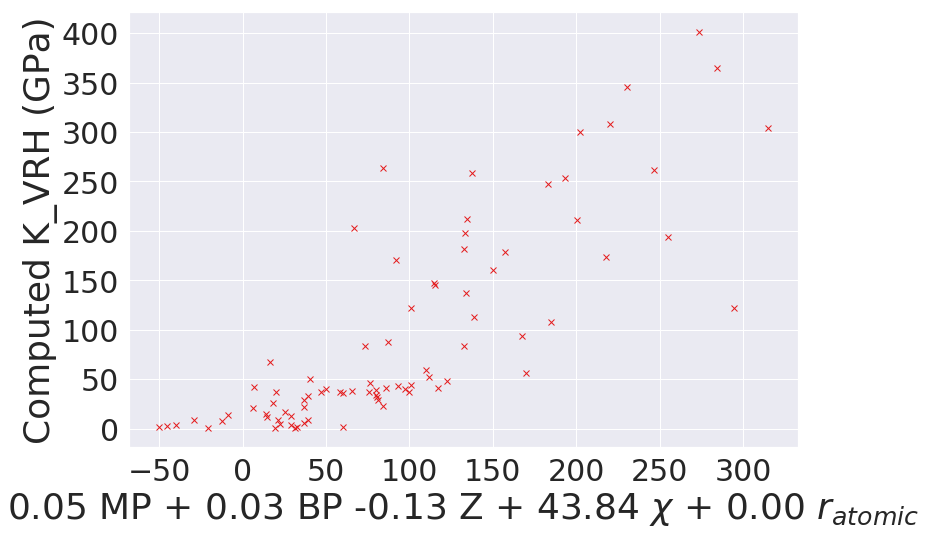

In [82]:
from pymatgen.util.plotting import pretty_plot
plt = pretty_plot(12, 8)
plt.plot(predicted_bulk_moduli, bulk_moduli_gs, "x")
plt.xlabel("%.2f MP + %.2f BP %.2f Z + %.2f $\chi$ + %.2f $r_{atomic}$" % tuple(reg.coef_))
plt.ylabel("Computed K_VRH (GPa)")